In [2]:
% matplotlib inline
import timeit
import math

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString

base1 = Polygon([
    (-32.1665052195, 244.951010361),
    (0.0, 0.0),
    (164.100332863, -6.72252704724),
    (258.444740993, 131.833417876),
    (81.6832775051, 124.859373939),
    (75.3190068965, 248.195464884),
    (-32.1665052195, 244.951010361),
])

base2 = Polygon([
    (-49.4396391714, 329.180218029),
    (-92.9129195885, 247.064021685),
    (-57.9893698290, 147.064434513),
    (10.0375541578, 123.960950894),
    (42.1257258497, 41.8152313633),
    (0.0, 0.0),
    (243.639444075, -12.0928970791),
    (165.344305147, 76.4704567905),
    (128.122025984, 171.451444998),
    (75.3190068965, 248.195464884),
    (11.3210810255, 302.371185501),
    (-16.9165100634, 338.309937796),
    (-49.4396391714, 329.180218029)
])

base3 = Polygon([
    (-1.51418765128, -3.10820900539),
    (264.175873958, -3.10820900539),
    (264.175873958, 263.865379471),
    (-1.51418765128, 263.865379471),
    (-1.51418765128, -3.10820900539)
])

base4 = Polygon([
    (7.47050042245, 4.59295220067),
    (65.2292094678, 301.087658634),
    (135.823187190, 337.026410929),
    (289.846411311, 369.114582620),
    (465.689592183, 347.294625870),
    (595.325805818, 225.359573441),
    (603.026967024, 88.0221985996),
    (440.019054829, -6.95878960841),
    (300.114626252, -74.9857135952),
    (7.47050042245, 4.59295220067),
])

base5 = Polygon([
    (9.73997200653, -0.429771980603),
    (32.7216291224, 291.150002677),
    (126.084611155, 396.003813268),
    (252.483725293, 434.785359651),
    (263.974553851, 351.476852606),
    (355.901182314, 253.804809863),
    (582.845046333, 207.841495632),
    (627.372006995, 46.9698958208),
    (465.064053614, 6.75199586810),
    (222.320300328, 146.078292133),
    (118.902843307, 35.4790672629),
    (9.73997200653, -0.429771980603)
])
series = [base1, base2, base3, base4, base5]

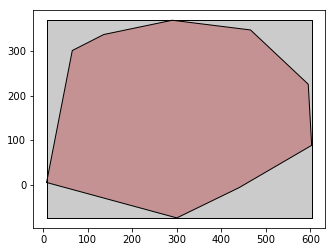

In [5]:
base = base4

gpd.GeoSeries([base,base.envelope]).plot()

0.74148075696376


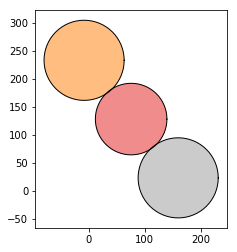

In [609]:
# gpd.GeoSeries(point_list).plot()

import random

from shapely.geometry import *


def generate_collection(min_r, max_r, resolution=16):
    envelope = base.envelope
    minx, miny, maxx, maxy = envelope.bounds
    number = 20
    x_diff = maxx - minx
    y_diff = maxy - miny
    point_list = []
    for j in range(number):
        for i in range(number):
            point = Point(minx + x_diff / number * i, miny + y_diff / number * j)
            if base.buffer(-20).contains(point):
                point_list.append(point)
                
    collection = []
    max_iteration = 1000
    iter = 0
    while len(point_list) > 0 or iter > max_iteration:
        iter += 1
        first_point = random.choice(point_list)
        if len(collection) == 0:
            r = random.randint(min_r, max_r)
            circle = first_point.buffer(r, resolution)
            collection.append(circle)
            point_list.remove(first_point)
        else:
            distances = [first_point.distance(circle) for circle in collection]
            min_distance = min(distances)
            if min_distance < min_r:
                point_list.remove(first_point)
            elif min_distance > max_r:
                continue
            else:
                circle = first_point.buffer(min_distance+1, resolution)
                collection.append(circle)
                point_list.remove(first_point)
    return collection


max_coverage = 0
current_collection = []
for i in range(10):
    # print(i)
    collection = generate_collection(60, 100, resolution=16)
    coverage = sum([geom.intersection(base).area for geom in collection]) / base.area
    # print(coverage, max_coverage)
    if coverage > max_coverage:
        max_coverage = coverage
        current_collection = collection
print(max_coverage)
# current_collection.append(base)
gpd.GeoSeries(current_collection).plot()

LINESTRING (-25.60244685580003 285.749512564735, 41.70802587689997 145.5883786146949)
LINESTRING (41.70802587689997 145.5883786146949, 159.5013531591249 22.94738640841)


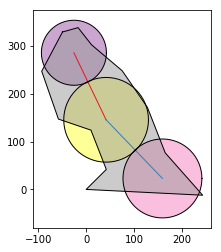

In [605]:
from shapely import affinity
roads = []
for i in range(len(current_collection)-1):
    for j in range(i+1, len(current_collection)):
        element1 = current_collection[i]
        element2 = current_collection[j]
        if element1.intersects(element2):
            roads.append(LineString([element1.centroid, element2.centroid]))
            print(LineString([element1.centroid, element2.centroid]))
roads.extend(current_collection)
roads.append(base)
gpd.GeoSeries(roads).plot()

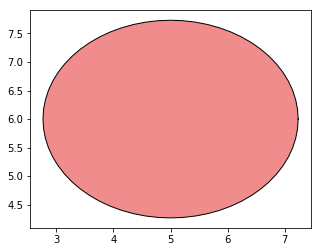

In [3]:
from mytry import get_eclipse
eclipse = get_eclipse(5, 3, (5, 6))
gpd.GeoSeries([eclipse]).plot()

(2.241150126735, -22.49571407856, 180.9080901072, 110.734374786) 17682.349051814203


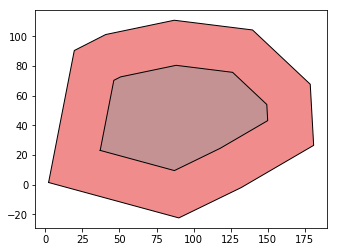

In [37]:
from shapely.affinity import *
our_base = scale(base4, xfact=0.3, yfact=0.3, origin=(0, 0))
print(our_base.bounds, our_base.area)
gpd.GeoSeries([our_base, our_base.buffer(-30)]).plot()

In [24]:
building_line = our_base.buffer(-10).boundary
building_line